# Periodic BC

## Manual solution

First, we calculate an example by hand to have something to compare against.

In [1385]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as scpl

In [1386]:
E = 2.1e9
nu = 0.3

In [1387]:
#stiffness tensor (Kelvin mapping)
C = E/(1-nu**2) * np.array([[1,nu,0],[nu,1,0],[0,0,1-nu]])
C

array([[2.30769231e+09, 6.92307692e+08, 0.00000000e+00],
       [6.92307692e+08, 2.30769231e+09, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.61538462e+09]])

In [1388]:
#undeformed coordinates
X_1 = np.array([0,0])
X_2 = np.array([1,0])
X_3 = np.array([1,1])
X_4 = np.array([0,1])
Xs = np.array([X_1,X_2,X_3,X_4])

In [1389]:
#prescribed displacements
u_1 = np.array([0,0])
u_2 = np.array([0.04,-0.03])
u_4 = np.array([0.05,0.04])

In [1390]:
#periodic bc
u_3 = u_4 + u_2 - u_1

In [1391]:
#deformed coordinates
us = np.array([u_1,u_2,u_3,u_4])
xs = np.array([X_1+u_1,X_2+u_2,X_3+u_3,X_4+u_4])

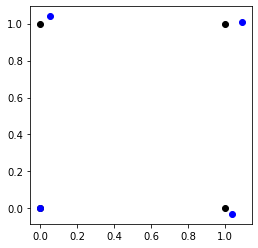

In [1392]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
for i in Xs:
    ax.plot(i[0],i[1],marker='o',color='black',ls='')
for i in xs:
    ax.plot(i[0],i[1],marker='o',color='blue',ls='')

In [1393]:
#Displacement gradient
Grad_u = np.array([[(u_2[0]-u_1[0])/(X_2[0]-X_1[0]),(u_4[0]-u_1[0])/(X_4[1]-X_1[1])],[(u_2[1]-u_1[1])/(X_2[0]-X_1[0]),(u_4[1]-u_1[1])/(X_4[1]-X_1[1])]])
Grad_u

array([[ 0.04,  0.05],
       [-0.03,  0.04]])

In [1394]:
#Deformation gradient
F = Grad_u + np.eye(2)
F

array([[ 1.04,  0.05],
       [-0.03,  1.04]])

In [1395]:
#small strain tensor
eps = (Grad_u + Grad_u.T)/2
eps

array([[0.04, 0.01],
       [0.01, 0.04]])

In [1396]:
#polar decomposition
R, U = scpl.polar(F)

In [1397]:
#stresses and strains as Kelvin vectors for computing analytical solution
eps_K = np.array([eps[0,0],eps[1,1],np.sqrt(2)*eps[0,1]])
eps_K

array([0.04      , 0.04      , 0.01414214])

In [1398]:
sig_K = C.dot(eps_K)
sig_K

array([1.20000000e+08, 1.20000000e+08, 2.28449883e+07])

In [1399]:
#stress tensor of analytical solution
sig = np.array([[sig_K[0],sig_K[2]/np.sqrt(2)],[sig_K[2]/np.sqrt(2),sig_K[1]]])
sig

array([[1.20000000e+08, 1.61538462e+07],
       [1.61538462e+07, 1.20000000e+08]])

In [1400]:
#strain in thickness direction (plane stress)
eps_33 = -nu * (sig[0,0]+sig[1,1]) / E
eps_33

-0.03428571428571429

In [1401]:
#Force on node 2 needed to stretch material
l_23 = X_3+u_3 - X_2-u_2
n_23 = l_23 / np.linalg.norm(l_23)
n_23 = np.array([n_23[1],-n_23[0]])
n_23
f_2=sig.dot(n_23)*np.linalg.norm(l_23)
f_2

array([1.23992308e+08, 1.08000000e+07])

In [1402]:
l_43 = X_4+u_4 - X_3-u_3
n_43 = l_43 / np.linalg.norm(l_43)
n_43 = np.array([n_43[1],-n_43[0]])
n_43
f_4=sig.dot(n_43)*np.linalg.norm(l_43)
f_4

array([2.04000000e+07, 1.25284615e+08])

## Calculation of corner node displacements from given deformation gradient

Let's see if we recover the corner node displacements we used to calculate the analytical solution above can be reproduced assuming only $\mathbf{F}$ is known:

$$
    [\mathbf{u}_1\ \mathbf{u_2}\ \mathbf{u_3} ] = (\mathbf{F} - \mathbf{I}) [\mathbf{X}_1\ \mathbf{X_2}\ \mathbf{X_3} ]
$$

In [1403]:
print("Original inputs:")
for u in us:
    print(u)

Original inputs:
[0. 0.]
[ 0.04 -0.03]
[0.09 0.01]
[0.05 0.04]


In [1404]:
print("Calculated from F:")
for X in Xs:
    print((F-np.eye(2)).dot(X))

Calculated from F:
[0. 0.]
[ 0.04 -0.03]
[0.09 0.01]
[0.05 0.04]


This confirms the use of the above equation.

## Averaging based on corner data

The following equation is given for obtaining the average deformation gradient:

$$
    \bar{\mathbf{F}} = \frac{1}{A_0} \left[
    (\mathbf{x}_4 - \mathbf{x}_1) \otimes \mathbf{N}_{43} \lVert \mathbf{X}_2 - \mathbf{X}_1 \rVert +
    (\mathbf{x}_2 - \mathbf{x}_1) \otimes \mathbf{N}_{23} \lVert \mathbf{X}_4 - \mathbf{X}_1 \rVert
    \right]
$$

In [1405]:
N_43 = np.array([0,1])
N_23 = np.array([1,0])
A_0 = np.linalg.norm(X_4-X_1) * np.linalg.norm(X_2-X_1)
A_0

1.0

In [1406]:
F_bar = ( np.outer(X_4+u_4 - X_1-u_1,N_43) * np.linalg.norm(X_2 - X_1) + np.outer(X_2+u_2 - X_1-u_1,N_23) * np.linalg.norm(X_4 - X_1)) / A_0
F_bar

array([[ 1.04,  0.05],
       [-0.03,  1.04]])

In [1407]:
print("Difference between defined and calculated: \n", F - F_bar)

Difference between defined and calculated: 
 [[0. 0.]
 [0. 0.]]


So this equation works nicely. Now let's calculate the stresses by

$$
    \bar{\boldsymbol{\sigma}} = \frac{1}{A} \text{sym}\, \left[
    (\mathbf{x}_4 - \mathbf{x}_1) \otimes \mathbf{f}_4 + (\mathbf{x}_2 - \mathbf{x}_1) \otimes \mathbf{f}_2
    \right]
$$

In [1408]:
A = np.linalg.norm(X_4+u_4 - X_1-u_1) * np.linalg.norm(X_2+u_2 - X_1-u_1)
A

1.0832997046062554

In [1409]:
temp = np.outer(X_4+u_4 - X_1-u_1,f_4) + np.outer(X_2+u_2 - X_1-u_1,f_2)
sig_bar = (temp + temp.T)/(2*A)
sig_bar

array([[1.19977878e+08, 1.61508682e+07],
       [1.61508682e+07, 1.19977878e+08]])

In [1410]:
print("Relative difference between defined and calculated: \n", (sig - sig_bar)/np.linalg.norm(sig))

Relative difference between defined and calculated: 
 [[1.29188750e-04 1.73907933e-05]
 [1.73907933e-05 1.29188750e-04]]


There's a very small discrepancy linked to the shear parts of the deformation, but in general it works.

## Back-calculation of material parameters

In [1411]:
#hydrostatic stress
p = np.trace(sig_bar)/3

In [1412]:
#strain from average deformation gradient
Grad_u_bar = F_bar - np.eye(2)
eps_bar = (Grad_u_bar + Grad_u_bar.T)/2
eps_3D = np.append(np.append(eps_bar,[[0,0]],axis=0),[[0],[0],[0]],axis=1)
eps_3D[2,2] = eps_33
eps_3D

array([[ 0.04      ,  0.01      ,  0.        ],
       [ 0.01      ,  0.04      ,  0.        ],
       [ 0.        ,  0.        , -0.03428571]])

In [1413]:
#volume strain
e = np.trace(eps_3D)

In [1414]:
#bulk modulus
K = p/e

In [1415]:
print("Ratio of back-calculated and original bulk modulus:",  K/(E/(3*(1-2*nu))))

Ratio of back-calculated and original bulk modulus: 0.9998156515640063


In [1416]:
#shear stress (if non-zero; otherwise invariants needed)
G = sig_bar[0,1]/(2.*eps_bar[0,1])

In [1417]:
print("Ratio of back-calculated and original shear modulus:",  G/(E/(2*(1+nu))))

Ratio of back-calculated and original shear modulus: 0.9998156515640072


So the material parameters can be correctly recovered.